In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from gc_orbitfit.fitting import LBFGSBFitter
from gc_orbitfit.gp_tools import sample_gp
from gc_orbitfit.data import load_sample_data
from gc_orbitfit.mcmc import MCMCSampler
from gc_orbitfit.models import GPNoiseModel, predict_resid
from gc_orbitfit.plotting import (
    plot_acor,
    plot_corner,
    plot_data,
    plot_resid,
    plot_trace,
)
from gc_orbitfit.priors import UniformPrior

warnings.filterwarnings("ignore")

In [2]:
data = load_sample_data()

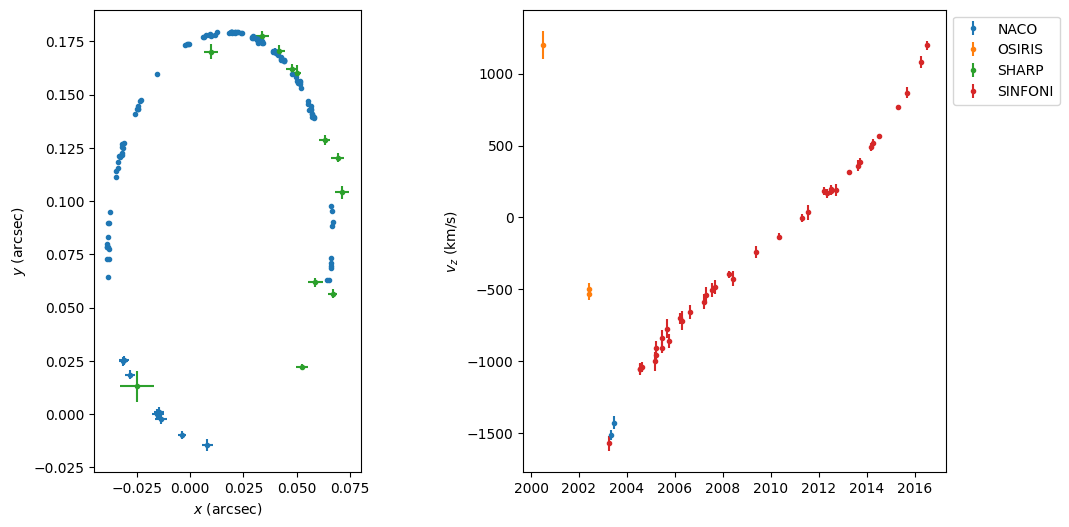

In [3]:
plot_data(data, figsize=(12, 6))
plt.show()

In [4]:
model = GPNoiseModel()

names, priors = zip(
    *[
        ("M0", UniformPrior(3, 5)),
        ("R0", UniformPrior(7, 9)),
        ("a", UniformPrior(0.10, 0.15)),
        ("e", UniformPrior(0.87, 0.90)),
        ("inc", UniformPrior(2.3, 2.5)),
        ("Omega", UniformPrior(3.9, 4.1)),
        ("omega", UniformPrior(1.0, 1.2)),
        ("tp", UniformPrior(2002.1, 2002.5)),
        ("x0", UniformPrior(-5e-3, 5e-3)),
        ("y0", UniformPrior(-5e-3, 5e-3)),
        ("vx0", UniformPrior(-1e-3, 1e-3)),
        ("vy0", UniformPrior(-1e-3, 1e-3)),
        ("vz0", UniformPrior(0, 50)),
        ("log_s2", UniformPrior(np.log(0.01e-6), np.log(1e-3))),
        ("log_taux", UniformPrior(np.log(0.01), np.log(5))),
        ("log_tauy", UniformPrior(np.log(0.01), np.log(5))),
    ]
)

In [5]:
sampler = MCMCSampler(data, names, priors, model, nwalkers=80, checkpoint="chain.h5")

In [6]:
# sampler.sample_orbit(10000, processes=32)

In [ ]:
sampler.restore()

In [8]:
sampler.nburn = 2000

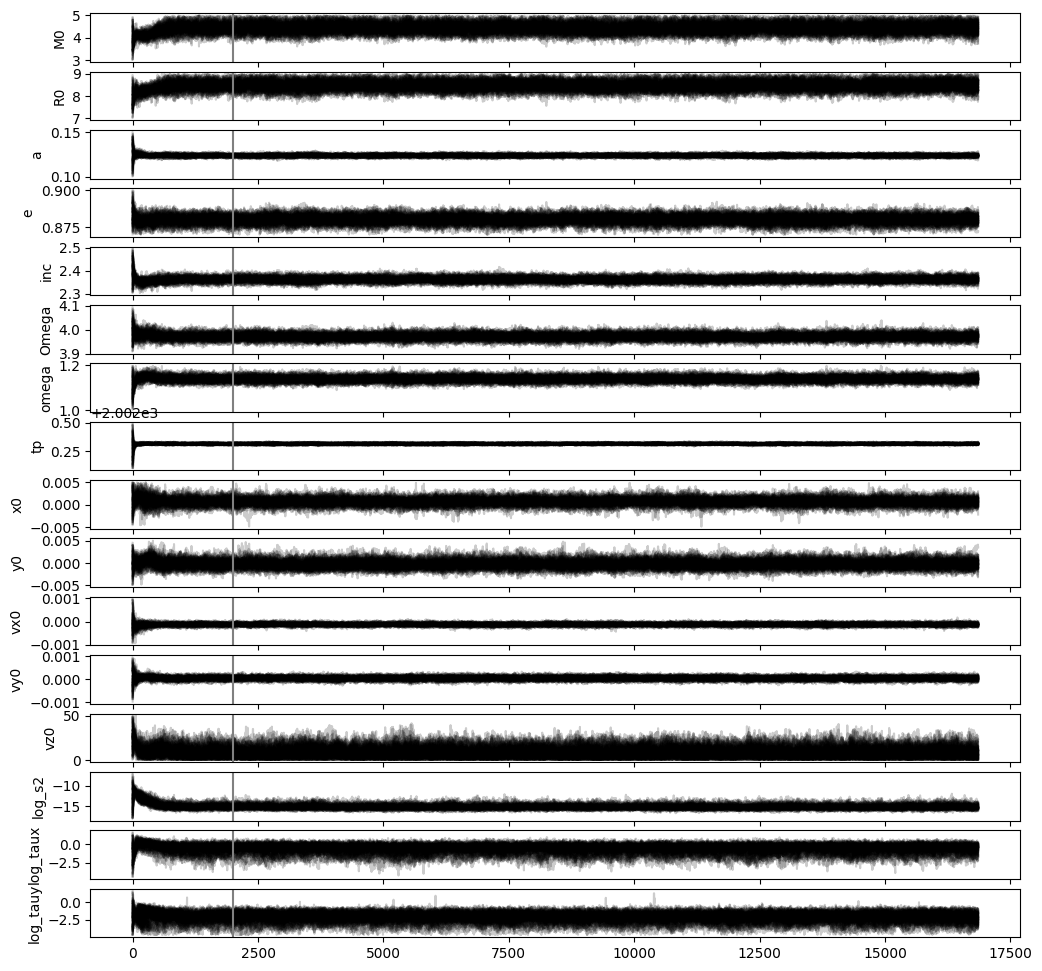

In [9]:
plot_trace(sampler, figsize=(12, 12))
plt.show()

In [10]:
# plot_trace(sampler, show_burnin=False, figsize=(12, 12))
# plt.show()

In [11]:
sampler.get_autocorr_time(quiet=True)

253.24617613061167

Compute autocorrelation times:   0%|          | 0/10 [00:00<?, ?it/s]

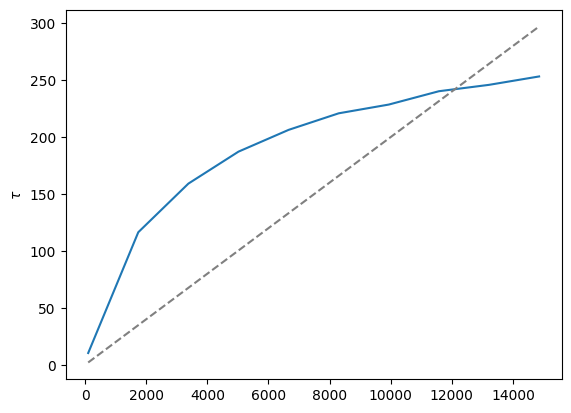

In [12]:
plot_acor(sampler)
plt.show()

In [13]:
theta0 = sampler.get_mean(as_array=True)
bounds = [prior.bounds() for prior in priors]

In [14]:
fitter = LBFGSBFitter(data, names, bounds, model)

In [ ]:
fitter.fit_orbit(theta0)

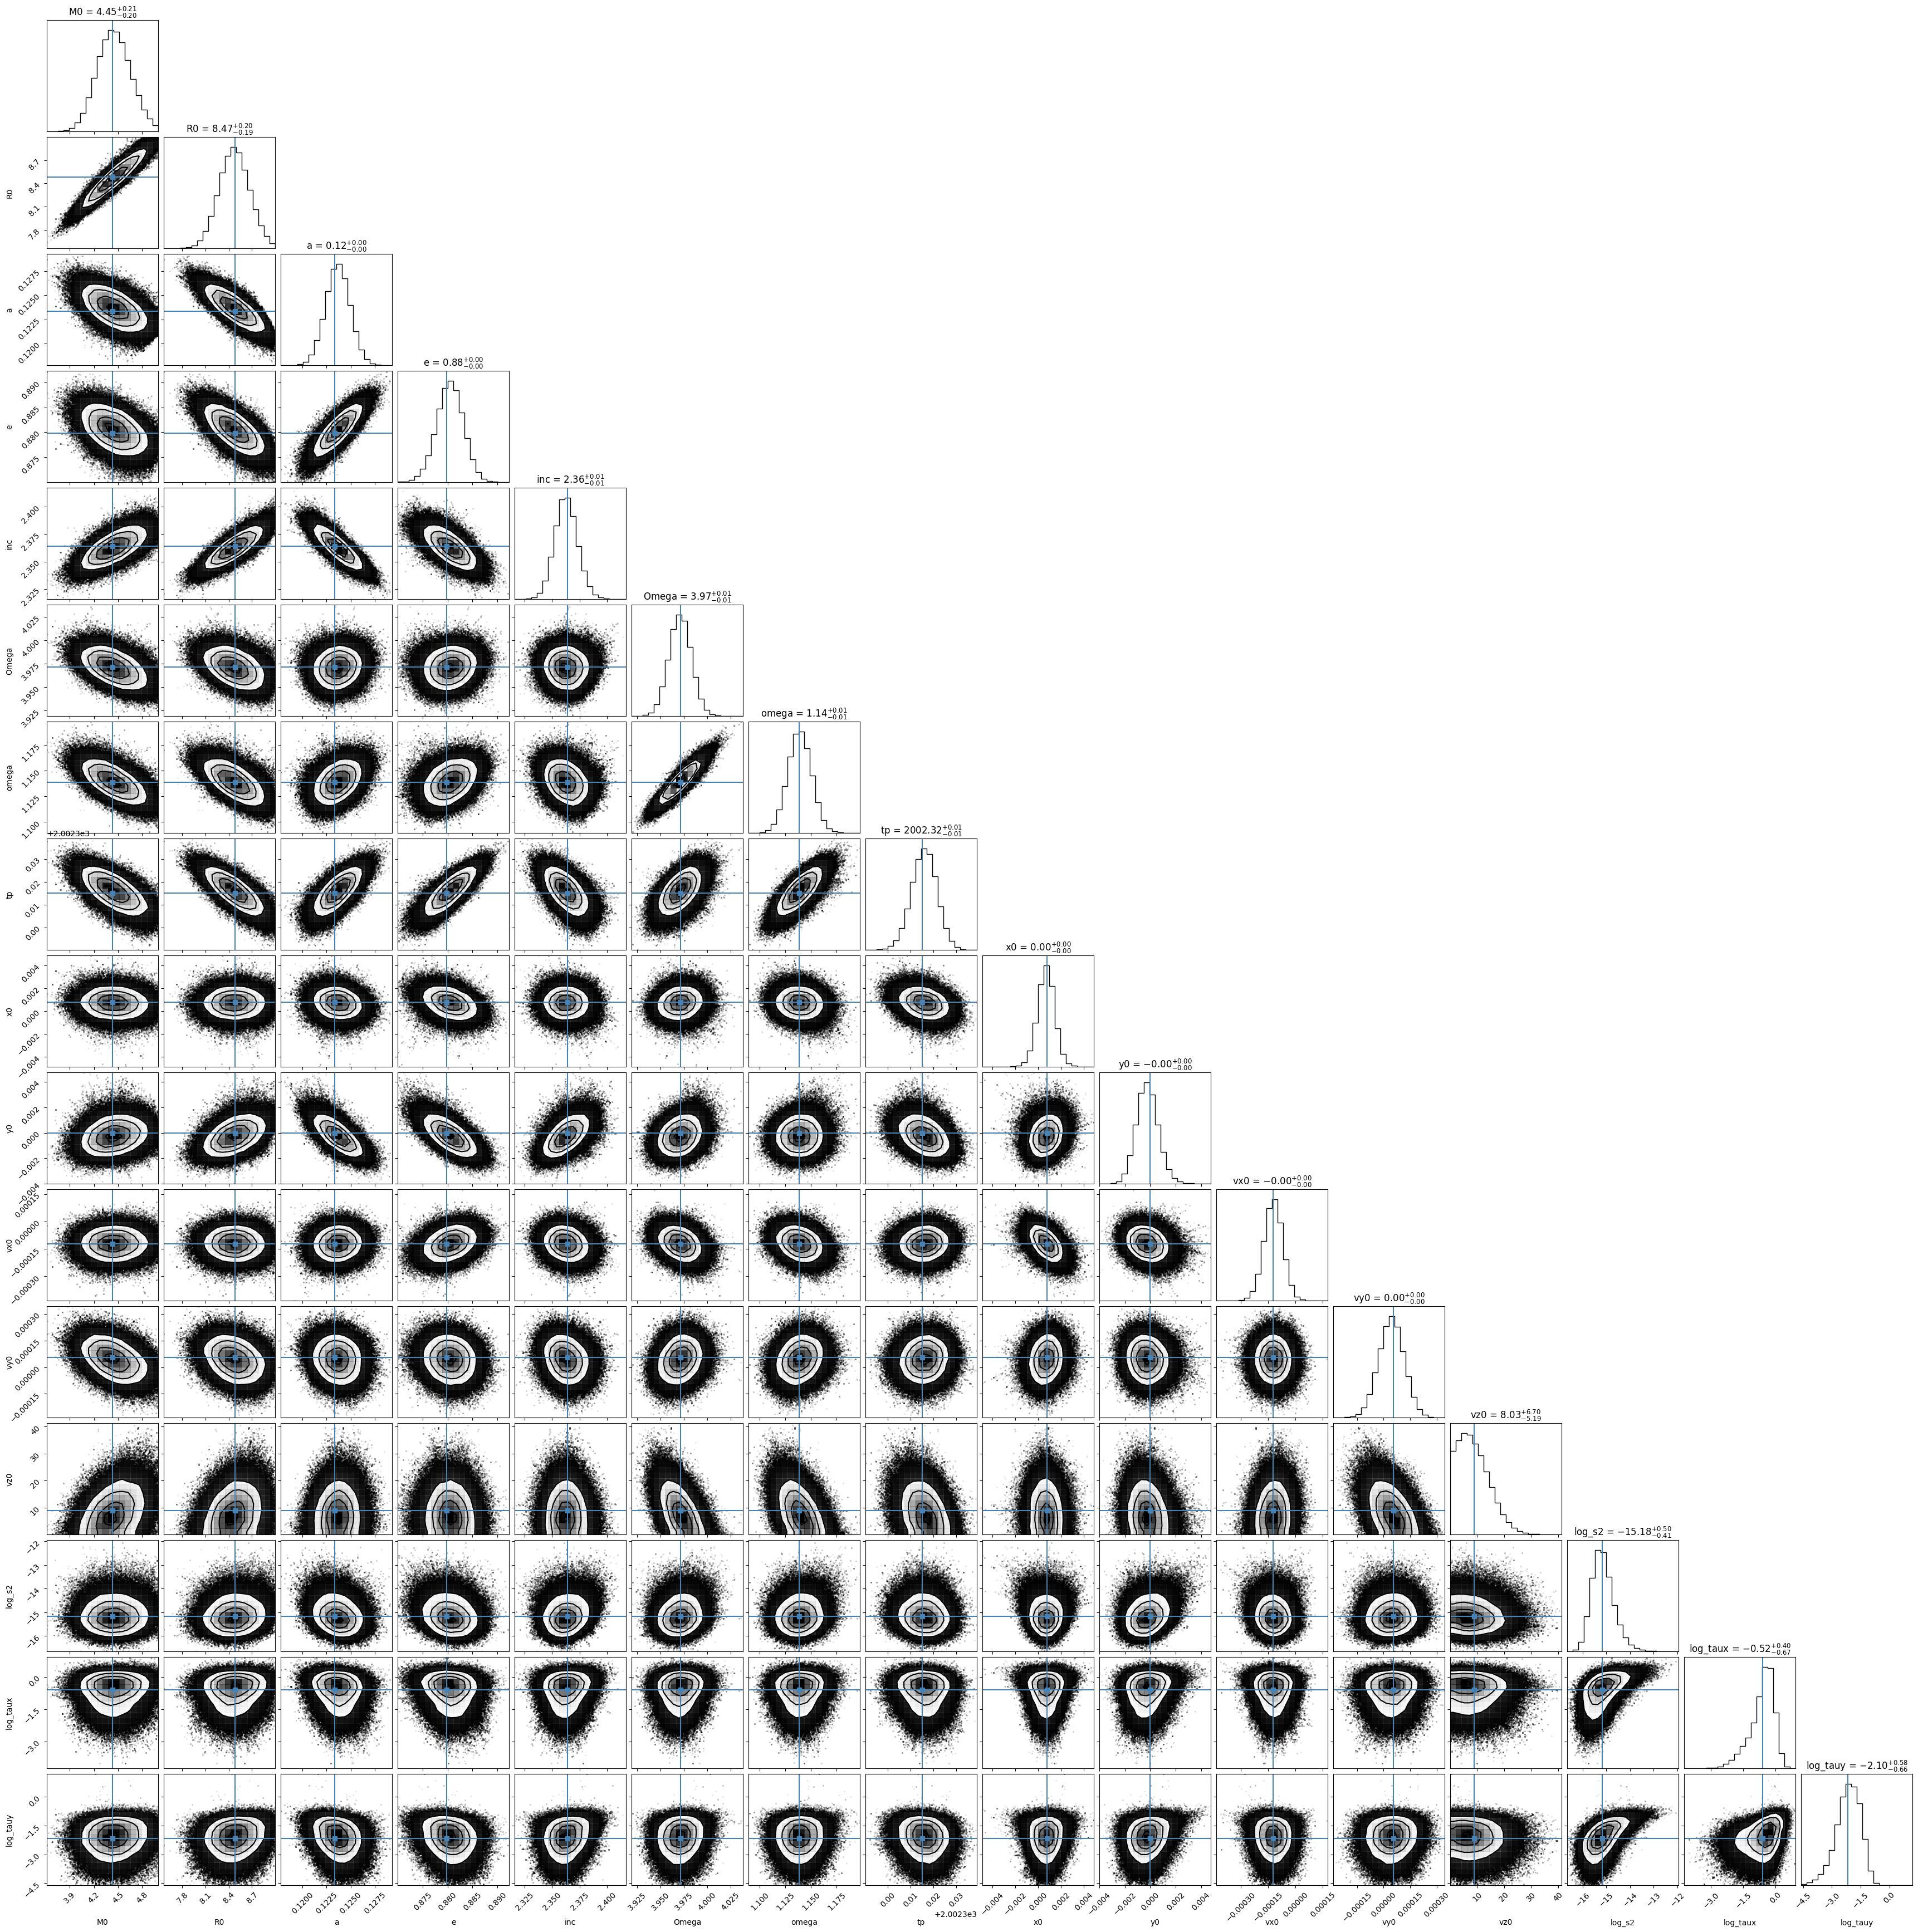

In [16]:
plot_corner(sampler, theta=fitter.get_best_fit(as_array=True))
plt.show()

In [17]:
best_orbit = fitter.get_best_fit()

In [18]:
best_orbit

{'M0': 4.42923768686608,
 'R0': 8.478375578054901,
 'a': 0.12333966879376353,
 'e': 0.8798487169250075,
 'inc': 2.364057010969295,
 'Omega': 3.971233950709869,
 'omega': 1.1382962852075655,
 'tp': 2002.3150610941057,
 'x0': 0.0008059810893315964,
 'y0': -1.9973038199580994e-05,
 'vx0': -0.00012130891003363383,
 'vy0': 5.4939013721128885e-05,
 'vz0': 8.811452096676797,
 'log_s2': -15.182307794659495,
 'log_taux': -0.6108208234212854,
 'log_tauy': -2.1518010830734253}

In [19]:
fit_resid = predict_resid(best_orbit, data, model)

Compute GP samples:   0%|          | 0/100 [00:00<?, ?it/s]

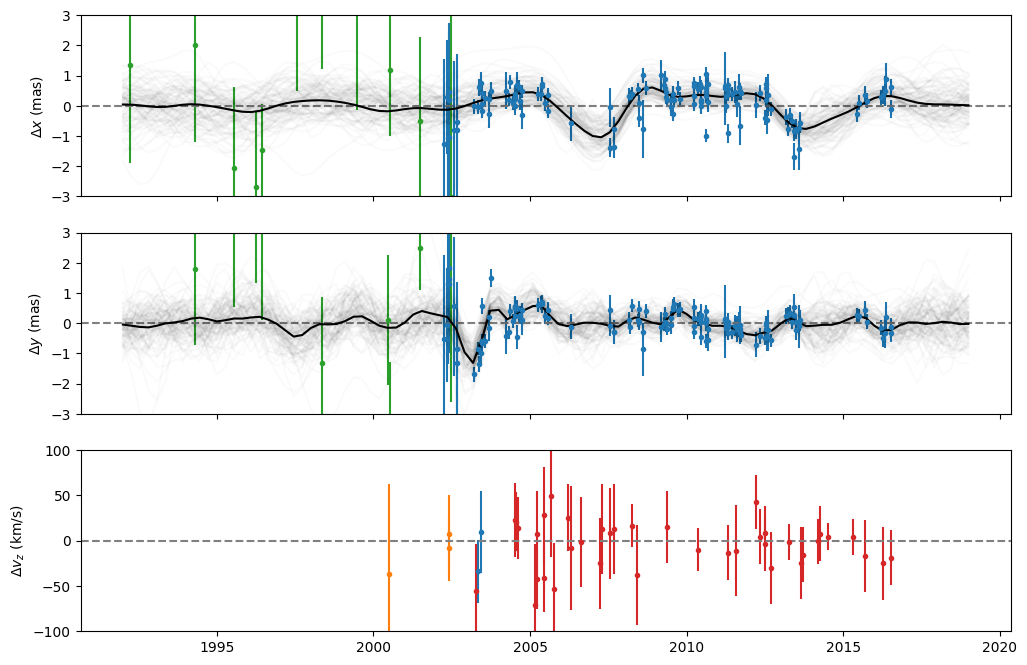

In [20]:
fig, ax = plot_resid(fit_resid, figsize=(12, 8))

t_val = np.linspace(1992, 2019, 100)

gp_mean = sample_gp(best_orbit, data, model, t_val, n=100)

gp_samples = pd.DataFrame(index=t_val)
for i in tqdm(range(100), desc="Compute GP samples"):
    df = sample_gp(sampler.get_sample(), data, model, gp_samples.index)
    gp_samples[[f"x-{i}", f"y-{i}"]] = df[["x", "y"]]

gp_mean *= 1e3
gp_samples *= 1e3

gp_samples.filter(regex="x-").plot(ax=ax[0], color="k", alpha=0.02, legend=None)
gp_samples.filter(regex="y-").plot(ax=ax[1], color="k", alpha=0.02, legend=None)
gp_mean.plot(ax=ax[0], y="x", color="k", legend=None)
gp_mean.plot(ax=ax[1], y="y", color="k", legend=None)

ax[0].set_ylim([-3, 3])
ax[1].set_ylim([-3, 3])
ax[2].set_ylim([-100, 100])

ax[0].legend_.remove()

plt.show()